In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# Selection of the active channels for the common mode noise determination
# Change the variables excludeDetectors and excludeChannels to provide the
# channels to be removed from the calculation, if all channels are to be
# used set the two variables to [].
# Numbering is from detector #0 (ch. #0 to ch. #7) to detector #3 (ch. #24
# to ch. #31)

global chMask

Mask = np.ones((32,1),dtype='int')
#excludeDetectors = [1,3]
#excludeChannels = [3,20]
excludeDetectors = [] #1,2,3
excludeChannels = []

for exclude in excludeDetectors:
    for i in range(8):
        Mask[exclude*8+i] = 0
for exclude in excludeChannels:
    Mask[exclude] = 0

chMask = (Mask > 0).nonzero()[0]
print('Common Mode Noise active channels are: {}'.format(chMask))

Common Mode Noise active channels are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [3]:
# Function used to determine the pedestals. It uses only the events where
# all signals are below thr. The algorithm calculates the pedestals channel
# by channel by removing iteratively the channels that fall outside the
# range -nsigma*sigma_i < mean_i < nsigma*sigma_i. nsigma has a default
# value of 3.0.
# The function returns the pedestals (mean) and the standard deviation of
# the values selected to determine the pedestals (std)

def Pedestals(ev, thr, nsigma=3.):
    sel = np.ones(ev.shape,dtype='int')
    for i in range(32):
        sel[:,i] *= (ev[:,i] <= thr[i])
    std = np.zeros_like(ev[0,:])
    mean = np.zeros_like(std)
    for i in range(32):
        idx = (sel[:,i] > 0).nonzero()[0]
        v = ev[idx,i]
        mean[i] = v.mean()
        stdprev = v.std()
        idx = (np.abs(v-mean[i]) < nsigma*stdprev).nonzero()[0]
        mean[i] = v[idx].mean()
        std[i] = v[idx].std()
        while (std[i] < stdprev):
            stdprev = std[i]
            idx = (np.abs(v-mean[i]) < nsigma*stdprev).nonzero()[0]
            mean[i] = v[idx].mean()
            std[i] = v[idx].std()
    return [mean, std]

In [4]:
# Function used to determine the common mode noise. It subtracts the pedestals
# from the ADC values and uses the same algorithm of the Pedestal function,
# this time event by event, to select the channels without signal.
# The function returns the common mode channel selection matrix (ch), the number
# of common mode channels on each event (chn), the raw common mode noise (mean),
# and the event standard devation of the common mode channels (std) that can be
# used to select events where the common mode can be calculated correctly (those
# with low std).

def CMNchannels(ev, peds, nsigma=3.):
    global chMask
    v = ev-peds
    v = v[:,chMask]
    ch = np.zeros_like(v)
    stdprev = v.std(axis=1).reshape(v.shape[0],1)
    std = np.zeros_like(stdprev)
    mean = v.mean(axis=1)
    chn = np.zeros_like(std)
    for i in range(v.shape[0]):
        vv = v[i,:]
        chmax = (vv == vv.max()).nonzero()[0]
        chidx = np.array(range(v.shape[1]))
        chidx = np.delete(chidx,chmax)
        stdprev[i] = vv[chidx].std()
        mean[i] = vv[chidx].mean()
        chidx = (np.abs(vv-mean[i]) < nsigma*stdprev[i])
        idx = chidx.nonzero()[0]
        mean[i] = vv[idx].mean()
        std[i] = vv[idx].std()
        while (std[i] < stdprev[i]):
            stdprev[i] = std[i]
            chidx = (vv-mean[i] < nsigma*stdprev[i])
            idx = chidx.nonzero()[0]
            mean[i] = vv[idx].mean()
            std[i] = vv[idx].std()
        ch[i,:] = chidx[:]
        chn[i] = len(idx)
    return [ch, chn, mean, std]

In [5]:
# Function used by the minimization to determine the common mode noise coupling
# to thee various channels (common mode noise "gain"). It uses global variables
# containing the pedestal subtracted event data and the common mode noise selection
# matrix.

def cmnGain(p):
    global cmnEv
    global cmnCh
    n = cmnEv.shape[0]
    g = np.array(p)
    I = np.ones((n,1))
    g_sum = (((np.outer(I, g))*cmnCh).sum(axis=1)).reshape(n,1)
    cmn = ((cmnEv*cmnCh).sum(axis=1)).reshape(n,1)
    cmn = cmn/g_sum
    cmn_matrix = np.outer(cmn, g)
    y = (((cmnEv-cmn_matrix)*cmnCh)**2).sum()
    return y

In [6]:
# Function used to remove the common mode noise from the event data. It uses
# the raw event data, the pedestals, the common mode channels selection matrix
# and the common mode noise coupling gains. The function returns the pedestal
# and common mode corrected event data (v) and the event common mode noise (cmn).
# Note: the common mode noise is removed only for the active channels

def removeDisturbances(ev, peds, ch, g):
    global chMask
    v = ev-peds
    vv = v[:,chMask]
    n = vv.shape[0]
    I = np.ones((n,1))
    g_sum = (((np.outer(I, g))*ch).sum(axis=1)).reshape(n,1)
    cmn = ((vv*ch).sum(axis=1)).reshape(n,1)
    cmn = cmn/g_sum
    cmn_matrix = np.outer(cmn, g)
    vv = vv-cmn_matrix
    for i,j in enumerate(chMask):
        v[:,j] = vv[:,i]
    return [v, cmn]

In [7]:
# Function used to determine the pedestals (ch_mean) and the noise (ch_std)
# after the pedestals and the common mode noise has been subtracted from the
# event data. The new pedestals should all be "zero" (within the noise limits)
# and the new noise standard deviations should be equal or smaller than the
# one calculated at the beginning by the pedestals determination function.

def histParameters(energy, thr, nsigma = 3.):
    ch_std = np.zeros(32)
    ch_mean = np.zeros(32)
    for i in range(32):
        idx = (energy[:,i] < thr).nonzero()[0]
        data = energy[idx,i]
        old_std = data.std()
        ch_mean[i] = data.mean()
        idx = (np.abs(data-ch_mean[i]) < nsigma*old_std).nonzero()[0]
        ch_std[i] = data[idx].std()
        ch_mean[i] = data[idx].mean()
        while (ch_std[i] < old_std):
            old_std = ch_std[i]
            idx = (np.abs(data-ch_mean[i]) < nsigma*old_std).nonzero()[0]
            ch_std[i] = data[idx].std()
            ch_mean[i] = data[idx].mean()
    return [ch_mean, ch_std]

In [8]:
# Load the file. Notice that this is very slow, be patient!

try:
    fname = 'self_americio_ch8_1hr.txt' # americio
    #fname = 'test_NO_americio_self_1hr_TH_214_8ch_tp4.txt' # no americio
    ev, evtype, module, chtype, channel, adc = np.loadtxt(fname, dtype='int', comments='#', usecols=(0, 1, 2, 3, 4, 5), unpack=True)
    N = np.unique(ev)
except:
    pass

In [9]:
# Print the number of events in the file
print('Events in file: ', len(N))
Event = []

idx = (module == 2).nonzero()[0]  # REMEMBER TO UPDATE THE MODULE NUMBER !!!!!!!!!!!!!!
evn = ev[idx]
ch = channel[idx]
val = adc[idx]

evnw = evn.view()
chw = ch.view()
valw = val.view()

# Determine the good events and store them in the Event list along with the event
# number and the channel numbers. This step eliminates all 0 and all 2047 events
# and the events where there is S&H saturation (changing the neg_saturation and
# the pos_saturation values can be used to play with saturation)

selected = 0
all_neg_saturation = 0
all_pos_saturation = 0
some_neg_saturation = 0
some_pos_saturation = 0
neg_saturation = 40.
pos_saturation = 2020.
if (len(N)):
    for n in N:
        # check only 40 rows at a time
        if (len(evnw) > 40):
            idx = (evnw[0:40] == n).nonzero()[0]
        else:
            idx = (evnw == n).nonzero()[0]
        # verify that the event contains 32 rows and all channels are present
        if ((len(idx) == 32) and (ch[idx].sum() == 496)):
            # verify saturation
            if ((valw[idx] <= neg_saturation).all()):
                all_neg_saturation += 1
            elif ((valw[idx] <= neg_saturation).any()):
                some_neg_saturation += 1
            elif ((valw[idx] >= pos_saturation).all()):
                all_pos_saturation += 1
            elif ((valw[idx] >= pos_saturation).any()):
                some_pos_saturation += 1
            else:
                Nch = chw[idx]
                ADCs = valw[idx]
                Event.append([n, Nch, ADCs])
                selected += 1
        ii = len(idx)
        evnw = evnw[ii:].view()
        chw = chw[ii:].view()
        valw = valw[ii:].view()

# Plot the good/bad events statistics
print('Real events: ', selected+all_neg_saturation+some_neg_saturation+all_pos_saturation+some_pos_saturation)
print('All negative saturated: ', all_neg_saturation)
print('Some negative saturated: ', some_neg_saturation)
print('All positive saturated: ', all_pos_saturation)
print('some positive saturated: ', some_pos_saturation)
print('Selected: ', selected)

Events in file:  1998631
Real events:  1998630
All negative saturated:  0
Some negative saturated:  771
All positive saturated:  347
some positive saturated:  0
Selected:  1997512


In [10]:
# Prepare the event and pedestal variables for the analysis

global events
global peds
n = len(Event)
peds = np.zeros((1, 32))
events = np.empty((n, 32))
for i, data in enumerate(Event):
    events[i,:] = data[2]

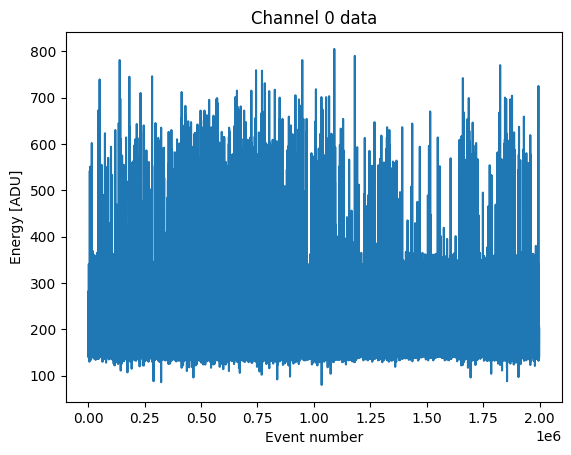

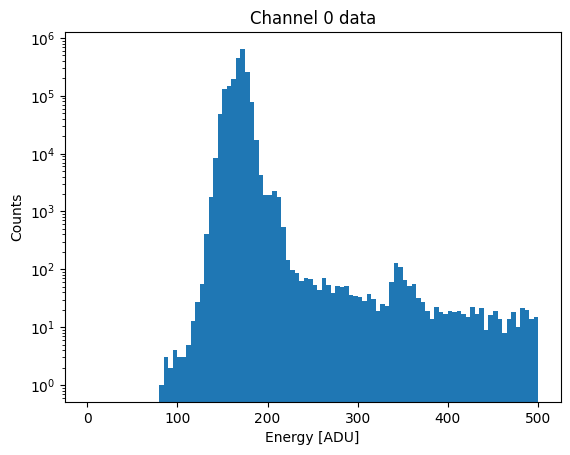

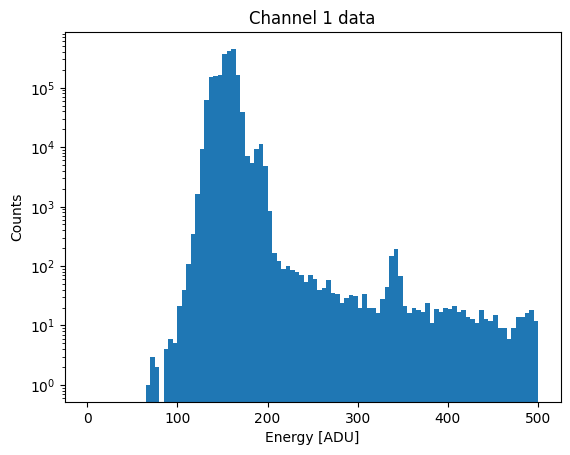

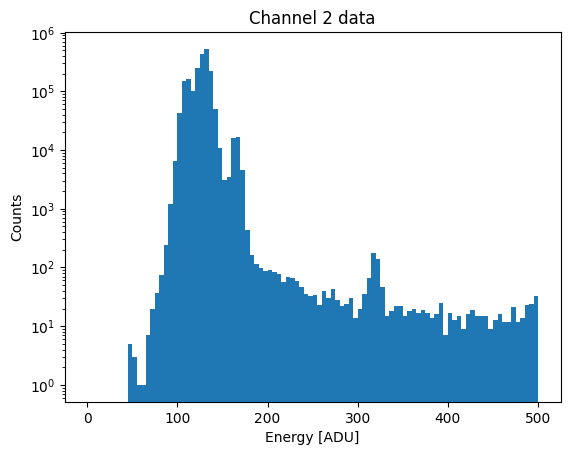

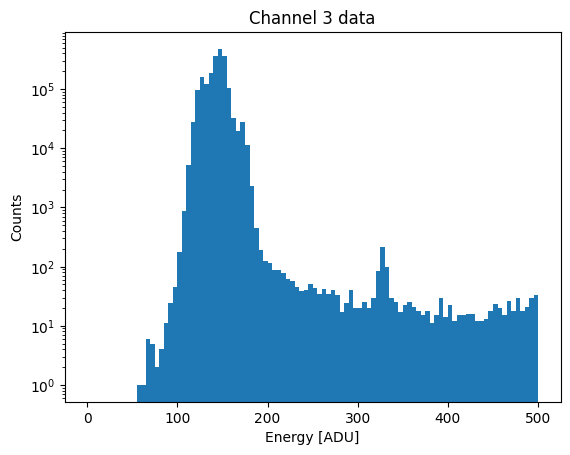

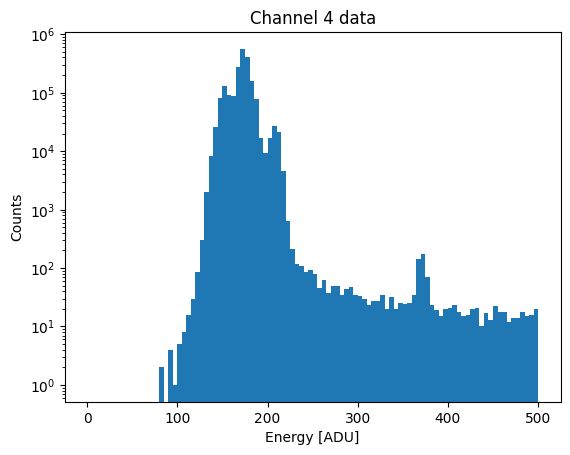

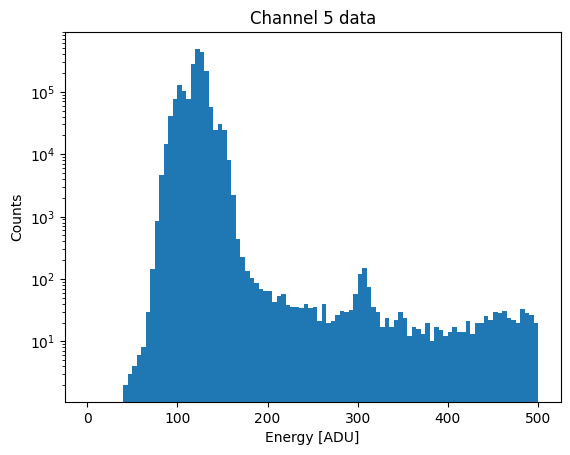

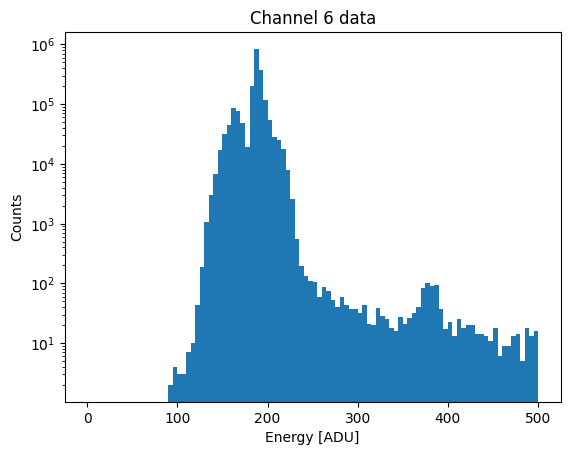

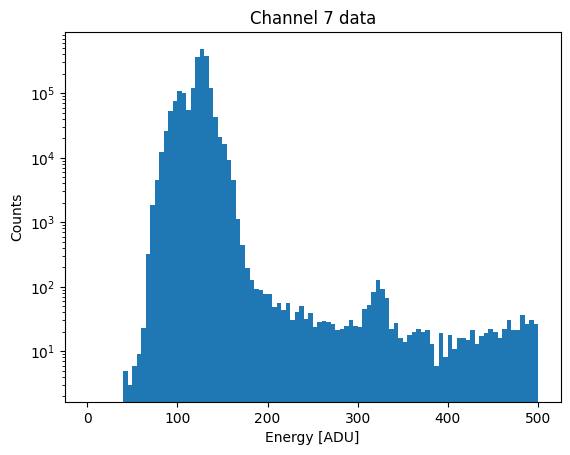

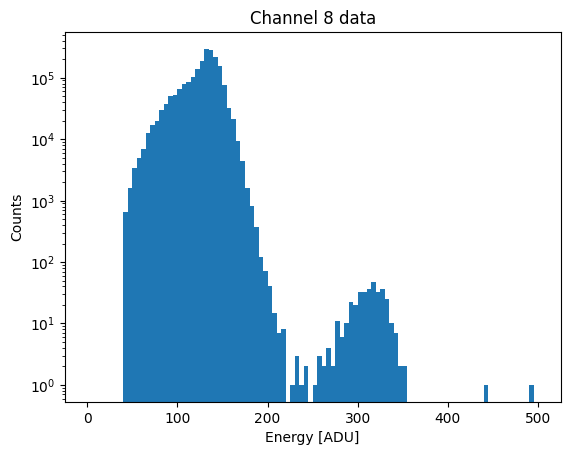

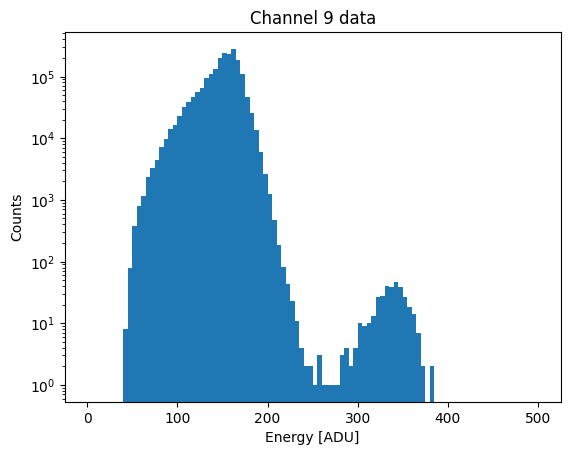

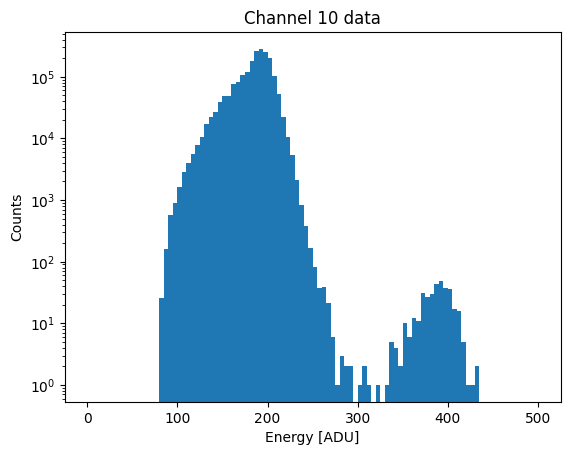

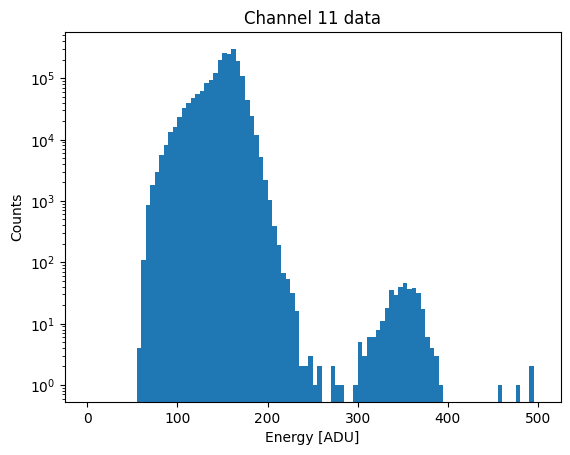

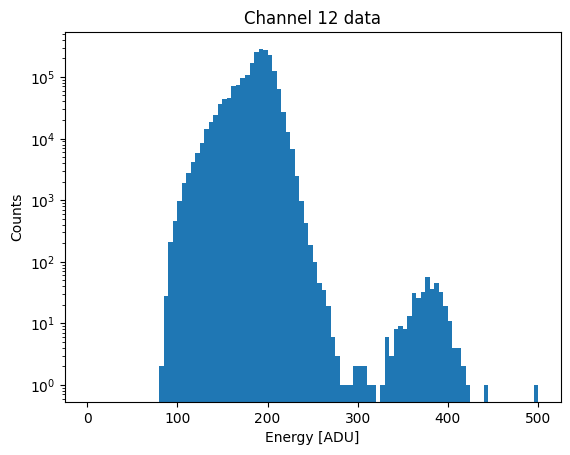

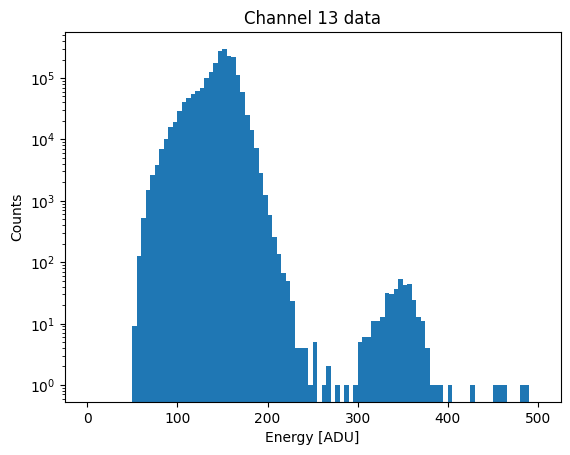

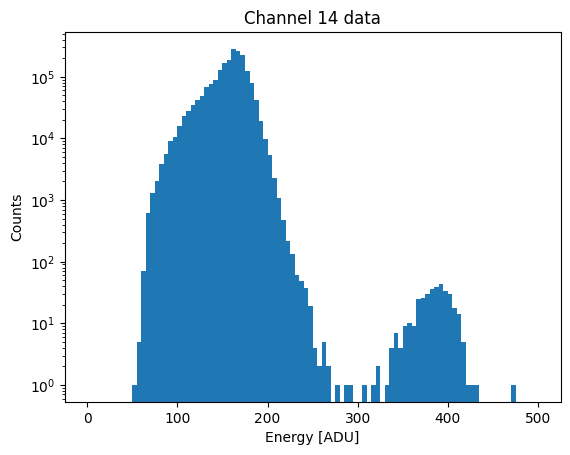

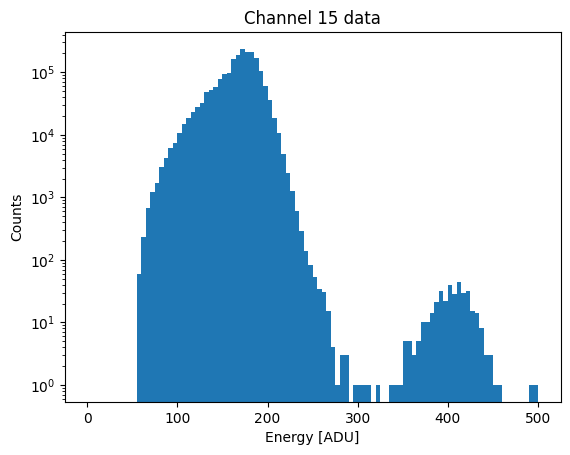

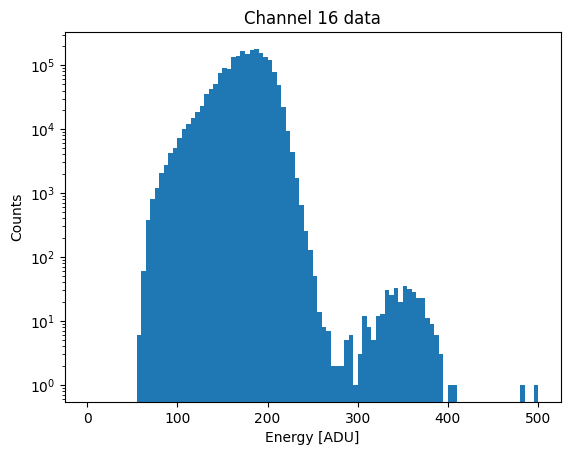

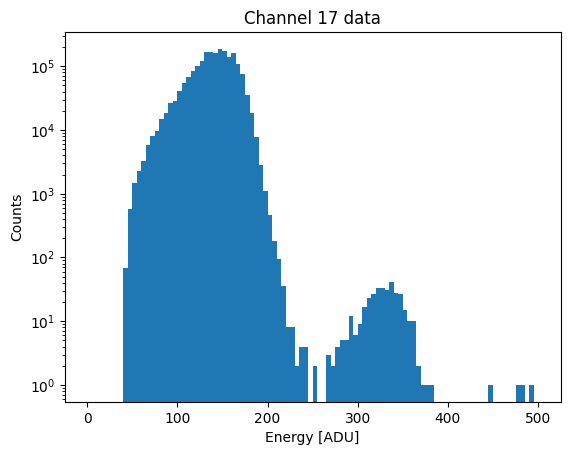

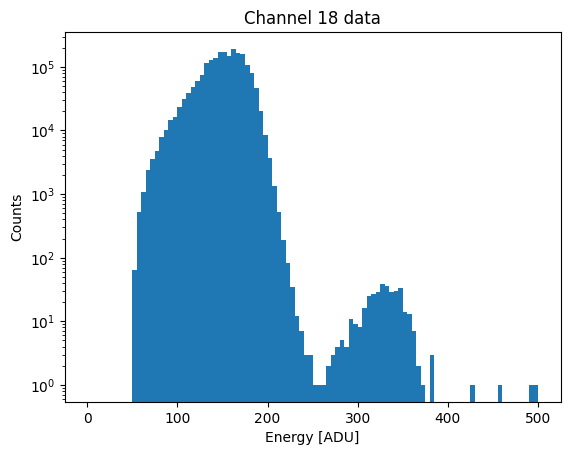

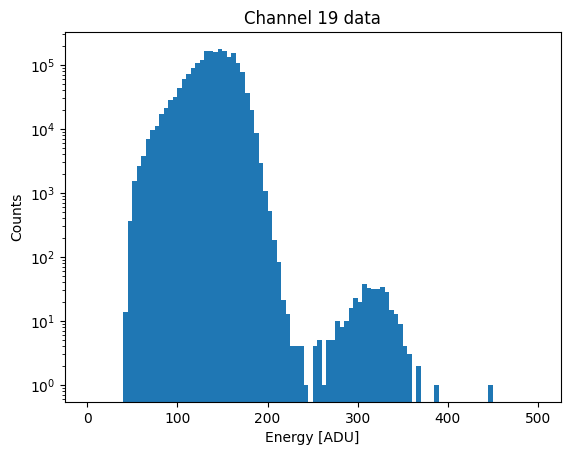

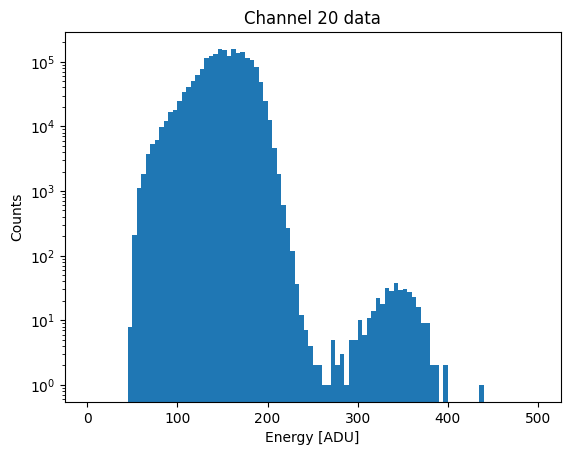

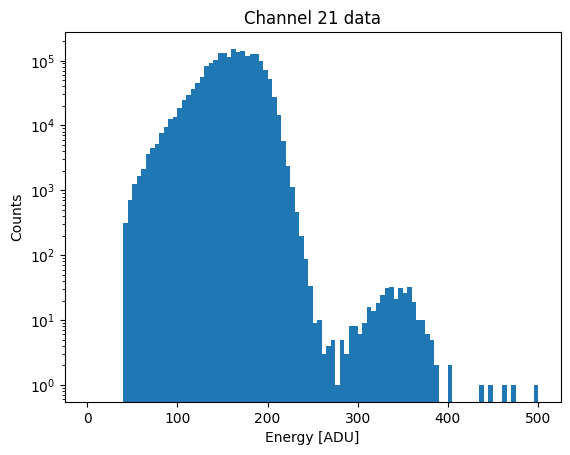

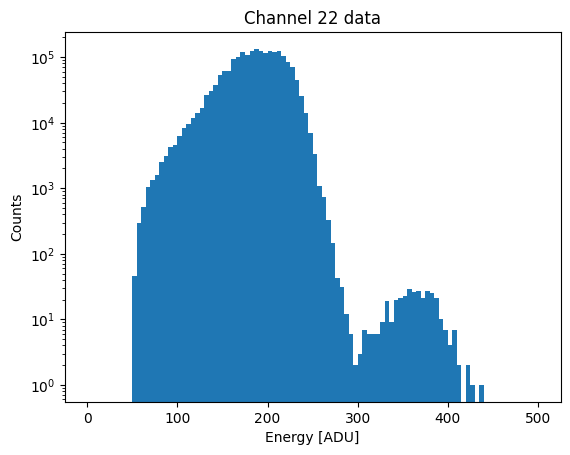

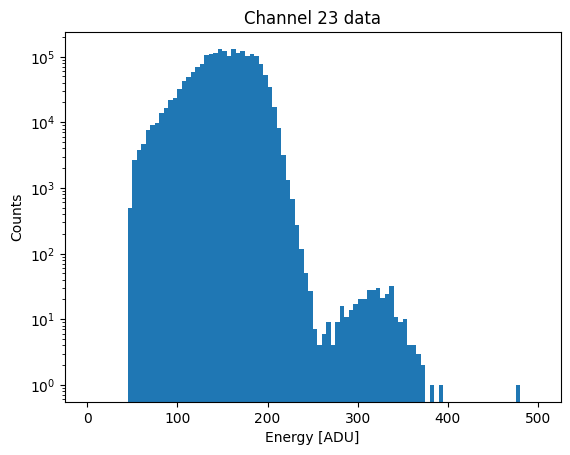

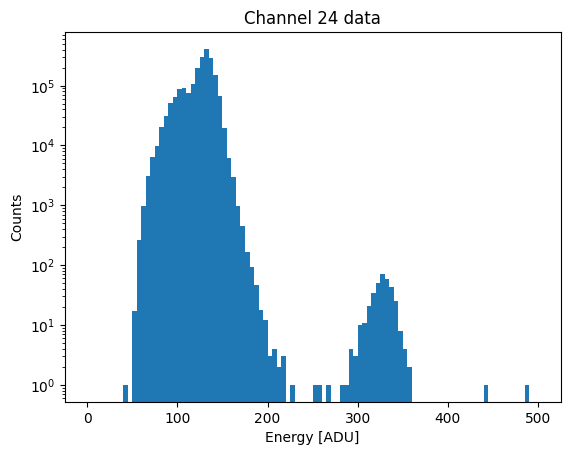

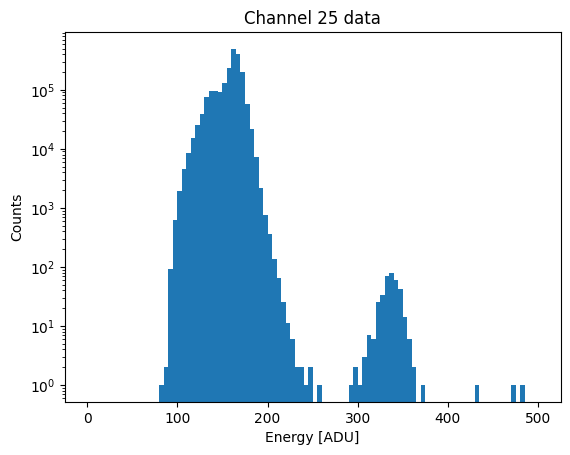

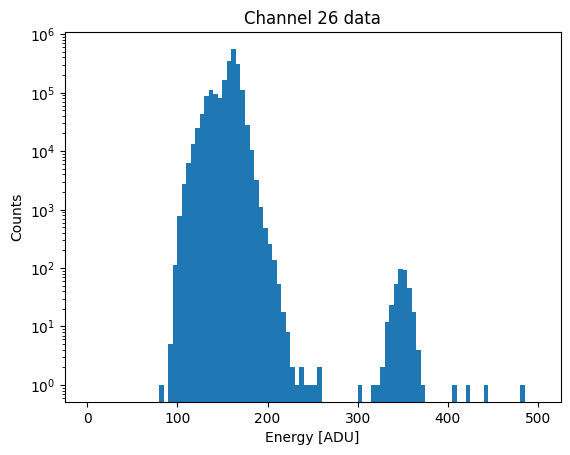

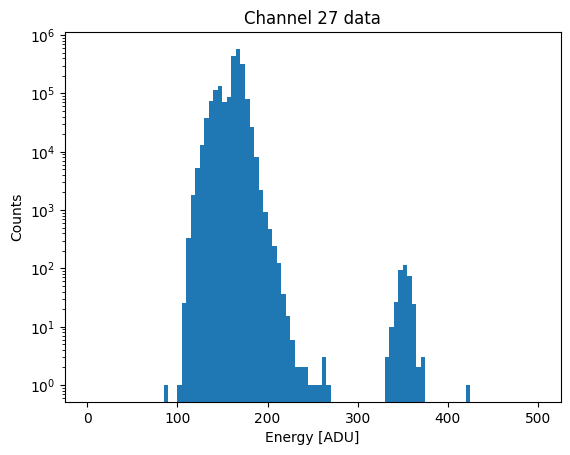

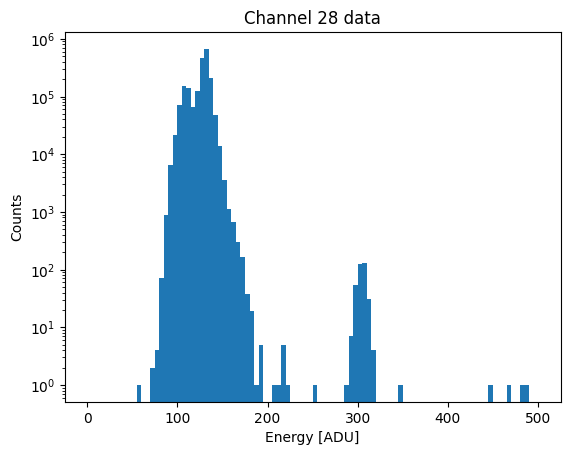

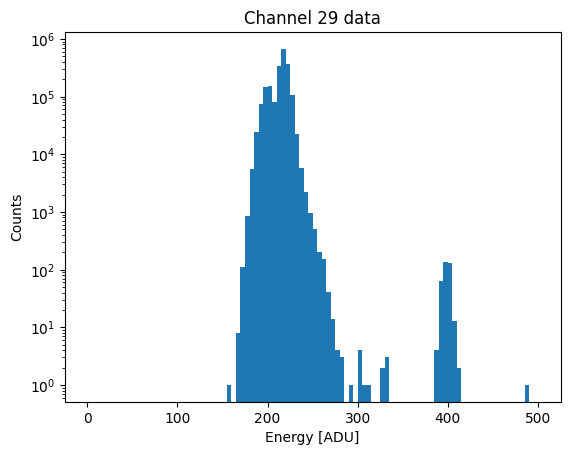

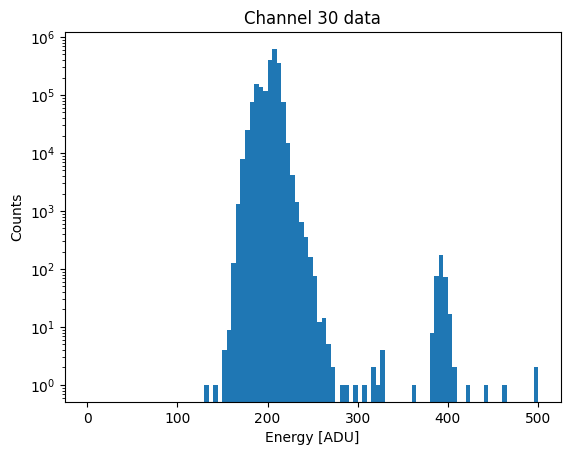

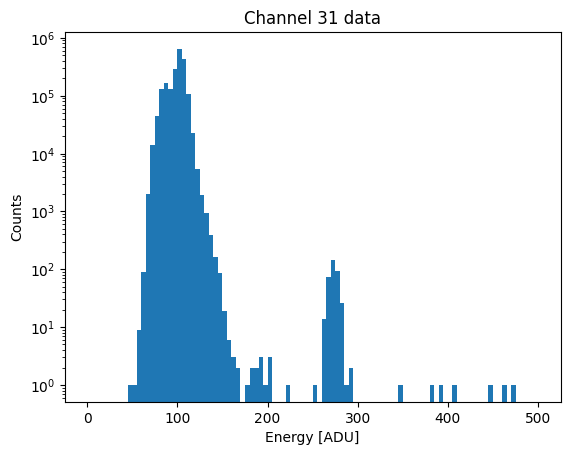

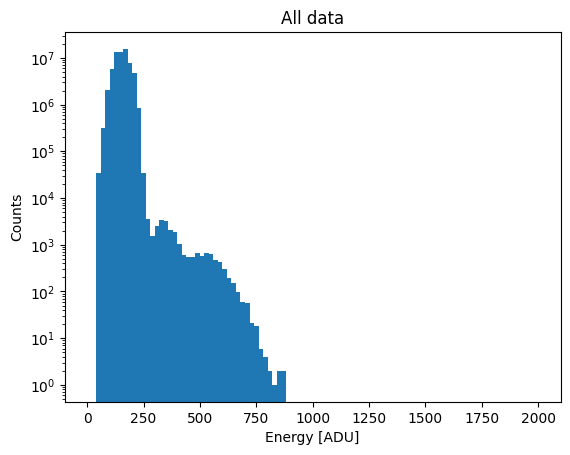

Channel averages:
 [168.29597119 154.65832295 126.55475812 143.61156328 171.49202558
 120.93176912 185.56940584 122.38854034 126.45291743 148.47827097
 184.12804028 149.21492587 185.89424294 145.10446846 156.04944
 166.80007479 174.15769968 139.33685605 150.38284376 138.50837492
 151.55188855 159.33234494 185.80367627 151.7145479  124.6580401
 157.5976675  155.81855929 161.41365709 125.72550102 213.53174199
 202.77694652  99.14356159] 



In [11]:
# Plot raw data histograms channel by channel (also the sequential data aquisitions
# for channel 0) and all together

i = 0
plt.plot(events[:,i])
plt.title('Channel {} data'.format(i))
plt.xlabel('Event number')
plt.ylabel('Energy [ADU]')
#plt.axis([0,200,0,200])
plt.show()
for i in range(32):
    plt.hist(events[:,i],100,(0,500))
    plt.semilogy()
    plt.title('Channel {} data'.format(i))
    plt.xlabel('Energy [ADU]')
    plt.ylabel('Counts')
    plt.show()

plt.hist(events.flatten(),100,(0,2000))
plt.semilogy()
plt.title('All data'.format(i))
plt.xlabel('Energy [ADU]')
plt.ylabel('Counts')
#plt.axis([0,200,0,200])
plt.show()

# Print the average values for all channels
print('Channel averages:\n', events.mean(axis=0), '\n')

In [12]:
# Determine the pedestals and print them along with their standard deviation and the
# difference between pedestals and channel mean value (this one just for sport)

#thr = [140, 140, 160, 150, 150, 140, 170, 130, 180, 150, 170, 170, 140, 200, 140, 190, 170, 150, 170, 190, 150, 150, 140, 200, 150, 150, 140, 130, 160, 130, 150, 140]
thr = [214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214]

peds, s = Pedestals(events, thr, 2.)
print('Pedestals:\n', peds, '\n')
print('Sigmas:\n', s, '\n')
print('Pedestals - Channel averages:\n', peds-events.mean(axis=0))

Pedestals:
 [170.88765885 157.39070452 129.52978834 146.45578775 173.12329671
 123.83951917 187.35351427 126.623582   135.02356938 155.73821807
 191.95179344 156.92648649 193.0241841  151.91386091 162.98792978
 174.44790985 179.54731672 144.36194009 155.50574566 143.59685144
 156.14140852 164.49448717 184.63151972 156.9701425  131.13593968
 163.41134667 161.07696159 166.17329386 130.42037925 205.30141493
 206.56455725 102.7791856 ] 

Sigmas:
 [ 3.68571077  4.8780416   4.80958073  5.3211558   4.16293712  4.58205455
  2.32461879  4.35031816  8.08419909  9.39669233  8.15292261  8.17231525
  8.14734948  8.17034771  9.64356927 11.29630103 16.92408338 15.86706749
 15.8104889  16.41723534 19.12222205 20.76150834 17.84343117 23.53290726
  6.08111001  4.9189688   4.5584988   3.6124867   3.31911099  7.28168995
  3.78737773  3.62354056] 

Pedestals - Channel averages:
 [ 2.59168766  2.73238156  2.97503022  2.84422447  1.63127113  2.90775005
  1.78410843  4.23504166  8.57065195  7.2599471   7.8237

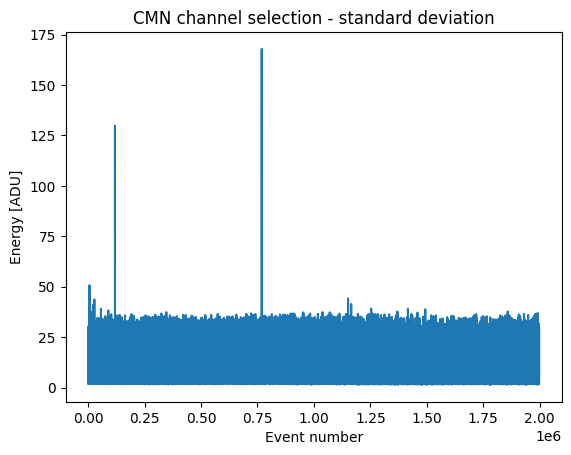

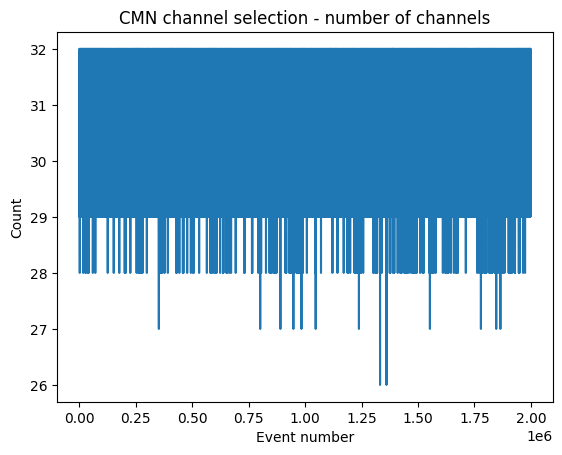

In [13]:
# Determine the common mode noise selection matrix and plot the standard deviation
# of the common mode channels and their number

ch, chn, CMNraw, std = CMNchannels(events,peds,3.)
plt.plot(std)
plt.title('CMN channel selection - standard deviation'.format(i))
plt.xlabel('Event number')
plt.ylabel('Energy [ADU]')
plt.show()
plt.plot(chn)
plt.title('CMN channel selection - number of channels'.format(i))
plt.xlabel('Event number')
plt.ylabel('Count')
plt.show()

In [14]:
## Determine the good events (common mode noise standard deviation lower than
# std_val) and print how many they are, prepare the global variables for the
# common mode gain determination step.

n = ch.shape[0]
std_val = 14.
idx = (std < std_val).nonzero()[0]
good = len(idx)
print('Number of good events (cmn std < {}): {}'.format(std_val, good))
global cmnEv
global cmnCh
cmnEv = events[idx,:]-peds
cmnEv = cmnEv[:,chMask]
cmnCh = ch[idx,:]

Number of good events (cmn std < 14.0): 1783935


In [15]:
# Find the common mode noise coupling to the channels (common mode noise gain).
# p are the parameters of the minimization (the gains). This is also slow...

p = np.ones((1,len(chMask)), dtype=float)

result = minimize(cmnGain, p, method='Nelder-Mead', options={'maxiter': 1e6, 'disp': True, 'adaptive': True})
# alternative minimization method with bounds
#bnds = np.ones((len(chMask),2), dtype=float)
#bnds[:,0] = 0.8
#bnds[:,1] = 1.2
#result = minimize(cmnGain, p, method='SLSQP', bounds=(bnds), options={'maxiter': 1e3, 'disp': True})

C:\Users\ghisl\AppData\Local\Temp\ipykernel_23924\401073919.py:6: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = minimize(cmnGain, p, method='Nelder-Mead', options={'maxiter': 1e6, 'disp': True, 'adaptive': True})


KeyboardInterrupt: 

In [ ]:
# remove the common mode noise (disturbances) from the event data, print the
# common mode noise gains, and plot the common mode noise along with the number
# of channels used to calculate it. The output is the variable Energy containing
# the pedestal and common mode noise subtracted event data for the good events
# (good as defined above)

g = result.x
print('Common mode gains:\n', g, '\n')
print('Sum of gains: ', g.sum())
idx = (std < std_val).nonzero()[0]
ev_good = events[idx,:]
ch_good = ch[idx,:]
energy, cmn = removeDisturbances(ev_good, peds, ch_good, g)
plt.plot(cmn)
plt.title('Common mode noise')
plt.xlabel('Event number')
plt.ylabel('Energy [ADU]')
plt.show()
plt.plot(chn)
plt.title('Number of channels used to calculate\n the common mode noise'.format(i))
plt.xlabel('Event number')
plt.ylabel('Counts')
plt.show()

In [ ]:
# Show correlation plots of the Energy data with respect to the common mode noise

for i in range(32):
    plt.plot(cmn, energy[:,i],'.')
    plt.title('Channel {} vs CMN'.format(i))
    plt.xlabel('Energy [ADU]')
    plt.ylabel('Energy [ADU]')
    plt.show()

In [ ]:
# Plot the Energy histogram for all channels. These histograms should have a
# pedestal peak and the MIP signal (if present)

for i in range(32):
    idx = (cmn < 10).nonzero()[0] # select the events where the signal is present
    plt.hist(energy[idx,i],220,(-100,120))
    plt.semilogy()
    plt.title('Channel {}'.format(i))
    plt.xlabel('Energy [ADU]')
    plt.ylabel('Counts')
    plt.axis([-50, 120, 0.3, 30000])
    plt.show()
    
import pandas as pd
my_df = pd.DataFrame(energy[idx, 4])
my_df.to_csv('ch4_americio.csv',header = False, index= False)
   

In [ ]:
# Plot the sum histogram of the Energy of all active channels. Keep in mind that the channel
# gains are not equalized, this should be performed in a further step when every channel
# has a muon peak
energyActive = energy[idx,:]
energyActive = energyActive[:,chMask]
plt.hist((energyActive).flatten(),220,(-100,120))
plt.semilogy()
plt.title('Sum histogram')
plt.xlabel('Energy [ADU]')
plt.ylabel('Counts')
plt.axis([-50, 120, 0.3, 3000000])
plt.show()

In [ ]:
# Determine the new pedestal and electronics noise of the channels after
# pedestal and common mode noise subtraction

pedestals, noise = histParameters(energy[idx,:], 50, nsigma = 3.)
print ('Histogram pedestals:\n', pedestals, '\n')
print ('Histogram standard deviations:\n', noise)

In [ ]:
# Plot the first 20 bad events (pedestal subtracted data) to have a look at them

idx = (std >= std_val).nonzero()[0]
ev_bad = events[idx,:]-peds
for i in range(min(20, len(idx))):
    plt.plot(ev_bad[i,:],'.')
    plt.title('Event {}'.format(idx[i]))
    plt.xlabel('Channel')
    plt.ylabel('Energy [ADU]')
    plt.show()